**A sneak peak into the NYPD traffic accident data**

In [2]:
import numpy as np
import re
import pandas as pd
import math
from sodapy import Socrata
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from mpl_toolkits.basemap import Basemap

In [3]:
# extract the data of traffic related accidents in new york
client = Socrata("data.cityofnewyork.us", None)

results = client.get("h9gi-nx95", limit=2*10**6)

# Convert to pandas DataFrame
nypd_df = pd.DataFrame.from_records(results)

In [4]:
# save the dara
nypd_df.to_pickle("./nypd.pkl")

In [4]:
# load the data
nypd_df=pd.read_pickle("./nypd.pkl")

In [6]:
# filter the data for the year 2018
nypd_df_2018=nypd_df[nypd_df['crash_date'].str.contains("2018")]

In [7]:
# find the vehicle codes for bikes
unique_list=nypd_df_2018["vehicle_type_code2"].unique().tolist()
unique_list=[str(s) for s in unique_list]
for string in unique_list:
    if re.findall("Bike|bike|cycle", string):
        print(string)

Motorcycle
Bike
Motorbike
Minicycle
Minibike


In [8]:
# filter the 2018 df by accidents where a bike has been one of the two vehicles
bike_related_df=nypd_df_2018[(nypd_df_2018["vehicle_type_code1"]=="Bike") | (nypd_df_2018["vehicle_type_code2"]=="Bike")]

In [11]:
# get the number of bike related accidents
len(bike_related_df)

6106

C:\Users\Paul\AppData\Local\Temp\ipykernel_1048\359769473.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude']=df['longitude'].astype(float)
C:\Users\Paul\AppData\Local\Temp\ipykernel_1048\359769473.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude']=df['latitude'].astype(float)


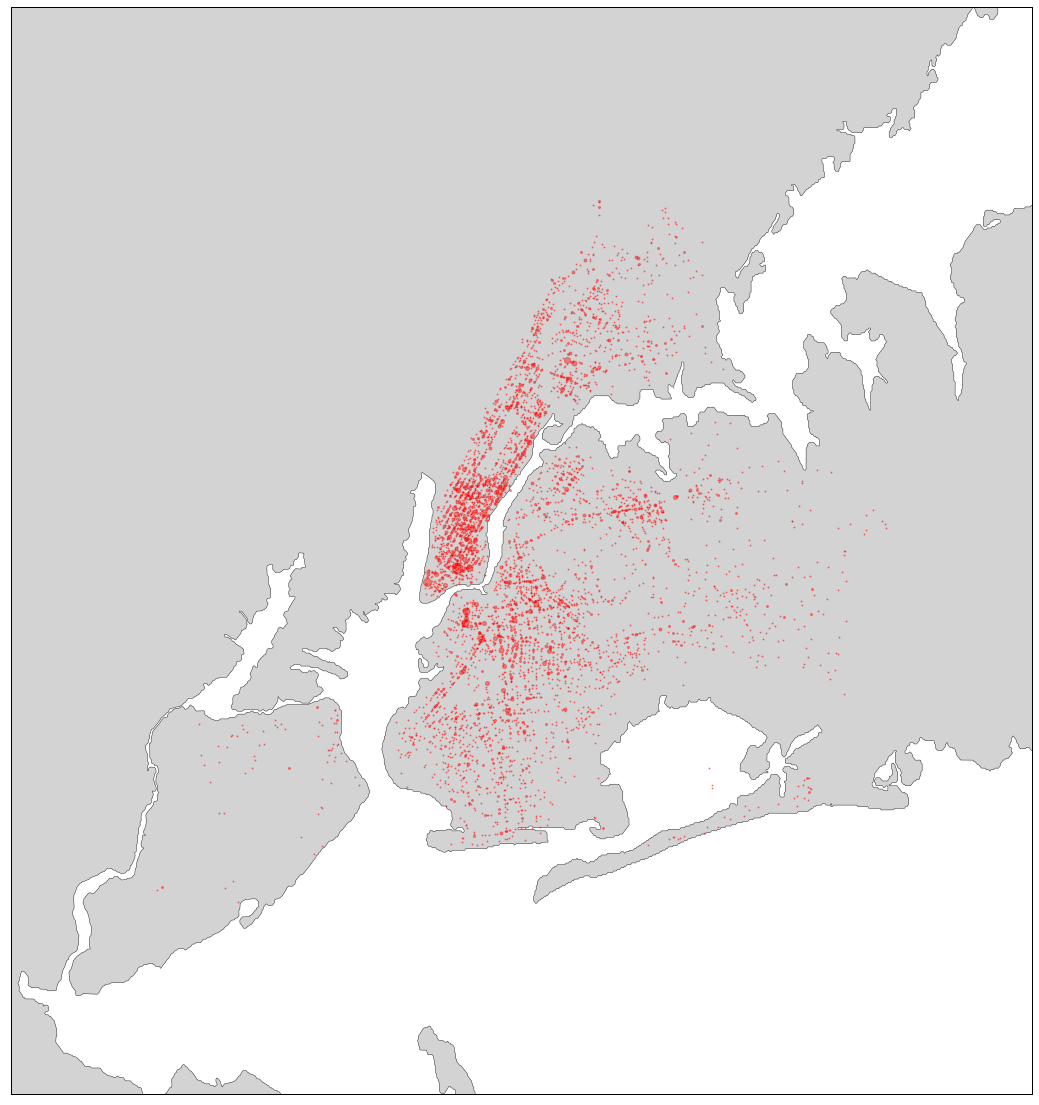

In [21]:
plot_map(bike_related_df, 0.1)

In [20]:
def plot_map(df, puffer):
    """
    Counts the occurances of coordinates and plots them on a map.
    The size of the marks differs by occurance.
    
    inputs:
      - df: a pandas dataframe
      - puffer: the margin for the map
    """
    
    %matplotlib inline
    df=df[~df["longitude"].isnull()]
    df['longitude']=df['longitude'].astype(float)
    df['latitude']=df['latitude'].astype(float)
    
    # only get data in NYC
    df=df[df["latitude"]>40]
    df=df[df["latitude"]<41]
    df=df[df["longitude"]>-74.2]
    df=df[df["longitude"]<-70]
    
    # Group the stations by coordinates
    # get the sum of rows with the same latitude
    df=df.groupby(["longitude", 'latitude'])["latitude"].agg('count').rename("count")
    df=df.to_frame().reset_index()
    lons = df['longitude'].values
    lats = df['latitude'].values
    count = df['count'].values
    
    puffer=puffer
    llcrnrlat=lats.min()-puffer
    urcrnrlat=lats.max()+puffer
    llcrnrlon=lons.min()-puffer
    urcrnrlon=lons.max()+puffer

    mpl.rcParams['figure.figsize'] = (20,20)
    m = Basemap(projection='merc',llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,\
                llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, resolution='f', area_thresh=50)

    m.drawmapboundary()
    m.drawcoastlines(color='black', linewidth=0.4)
    m.fillcontinents(color='lightgray')

    x,y = m(lons, lats)
    
    # iterate over the objects to set the individual size
    for x1, y1, c in zip(x, y, count):

        m.plot(x1, y1, 'ro', markersize=c, alpha=0.4)

    plt.show()